---
title: "Unsupervised Learning"
format:
    html: 
        code-fold: false
---

# Code 

In this section we want to try unsupervised learning techniques such as clustering and dimentionality reduction in an attempt to get a better understanding of our data.

The first unsupervised technique we used in a dimensionality reduction technique. The goal of such techniques is to compress the data down from a large number of attributes to 2-3 attributes so that we can visualize these attributes. There’s different options on how to do this with the main two being t-SNE and PCA. For our analysis we chose to use t-SNE due to the non-linear transformations the technique brings which can help show complex non-linear clusters that PCA would not be able to visualize in the same way. 

In [1]:
#Load data
import pandas as pd
df = pd.read_csv("../../data/Clean_Data/liar_dataset/train.csv")

In [2]:
#First couple rows
df.head()

,ID,Label,Statement,Subjects,Speaker,Job_Title,State_Info,Party,Barely_True_Count,False_Count,Half_True_Count,Mostly_True_Count,Pants_On_Fire_Count,Context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


We will start by doing some data preprocessing. Our steps are as follows

- Define function to clean data and apply the function to the statements in the liar liar dataset
- Construct a document-term matrix
- Do dimensionality reduction with NMF
- Plot the words most likely to appear in each topic and analyze

In [3]:
from nltk.corpus import stopwords
import string
stopwords = set(stopwords.words("english"))

def clean_statements(text):
    tmp = ''
    for i in text:
        if i.isdigit() != True and i not in string.punctuation:
            tmp = tmp + i

    text = tmp

    text = text.lower()

    tmp = ''
    tokenized_text = text.split()
    for i in tokenized_text:
        if i not in stopwords:
            tmp = tmp + i + " "

    text = tmp

    return text

df["Statement_Cleaned"] = df["Statement"].apply(clean_statements)

We start by removing punctuation marks, numbers, and replacing all uppercase letters with lowercase ones.  We will then remove common words that likely have give no information into the legitimacy of a news source. These words commonly called stop words such as ”the”, ”a”, and ”to” were removed using nltk.corpus’s stop words list. 

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.5)
dtm = vectorizer.fit_transform(df["Statement_Cleaned"])
dtm.shape

(10240, 161)

Next we will vectorize our data using the TfidfVectorizer. The point of this is to covert our textual data into a numerical format that can be processed by and learned from by a computer.

In [5]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
nmf_model = NMF(n_components=6, random_state=5000)
nmf_model.fit(dtm)

NMF(n_components=6, random_state=5000)

The next step is to use NMF topic modeling to bin the different words in our model into 6 different topics. These topics are assigned by the model with the only hyperparaemter we chose being the number of topics as 6. We chose this to explore how closely these 6 randomly generated clusters would align with the 6 truth categories. If we see that these topics assigned by the model have well defined clusters and contain largely one of the truth categories this would be a very good sign that we could use supervised learning techniques to predict the truthfulness of a statement. However, NMF doesn’t inherently align its clusters with external categories, so the clusters might not align perfectly.

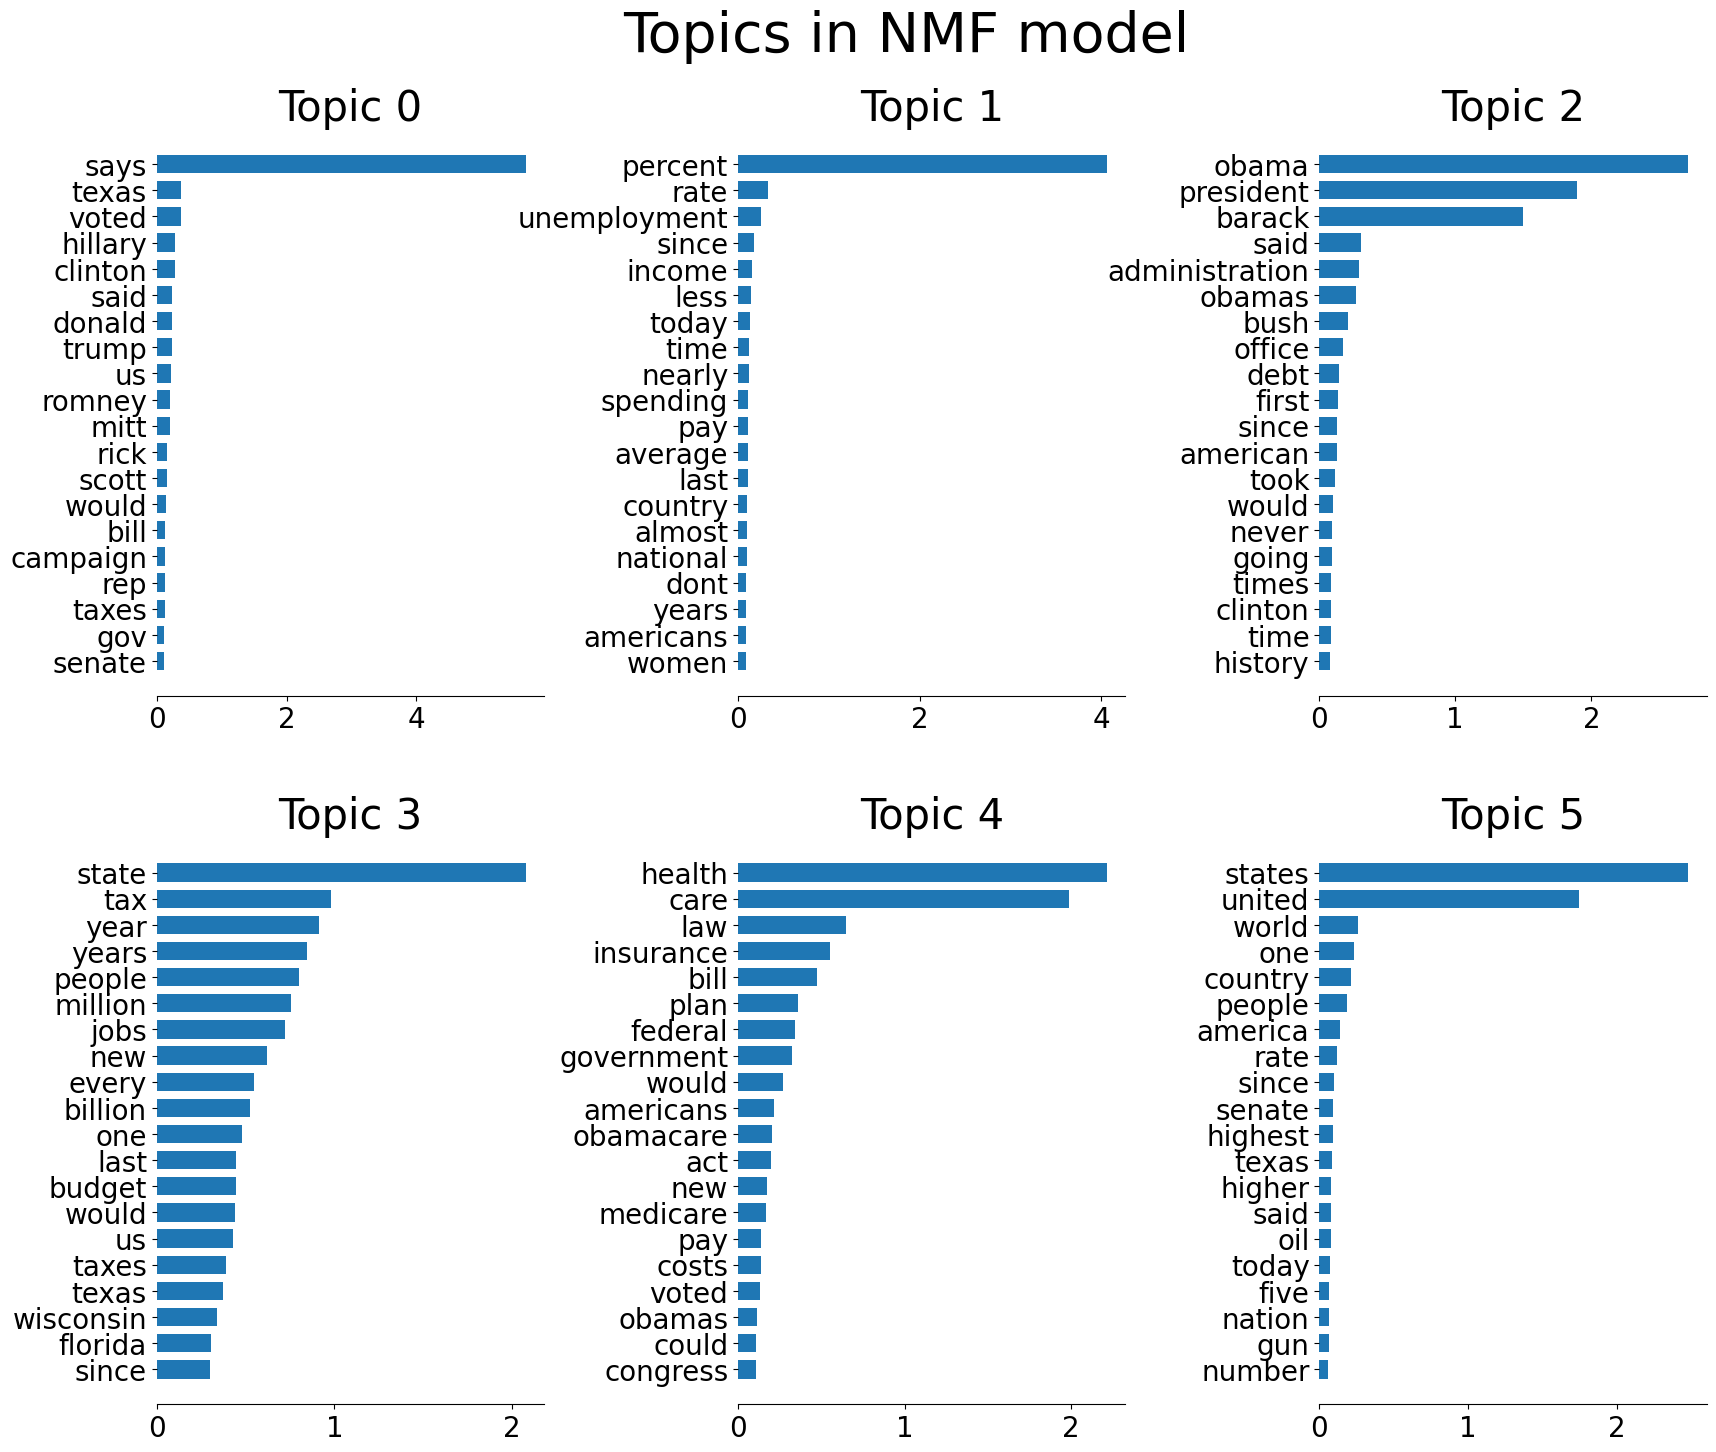

In [6]:
import matplotlib.pyplot as plt

def plot_top_words(model, word_list, n_top_words=20):
    fig, axes = plt.subplots(2, 3, figsize=(20, 15)) #, sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = word_list[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle("Topics in NMF model", fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.5, hspace=0.25)
    plt.show()

# Your code here (use plot_top_words() to display the distributions of top words
# for the four estimated topics)

plot_top_words(nmf_model, vectorizer.get_feature_names_out())

Here we simply take the results from the previous NMF model to create a graphic that shows the most common words in each topic. What we can see from the above graphic is that each topic has relatively different words that seem to represent different topics. For example topic 4 seems to be about healthcare mentioning insurance, health, care, bill, obamacare, and many others as some of the most common words. Similar thinking could be applied to the other topics as well.

Finally we get to t-SNE our dimensionality reduction technique that we will use the lower the number of dimensions in our text dataset in order to plot it in a 2 dimensional plane.

In [7]:
term_topic_df = pd.DataFrame(nmf_model.components_.T)
term_topic_df.head()

,0,1,2,3,4,5
0,0.031090,0.002590,0.024015,0.044204,0.195420,0.000000
1,0.000000,0.033593,0.024379,0.106482,0.031424,0.028464
2,0.000000,0.011236,0.292610,0.061035,0.026381,0.004829
3,0.000000,0.098518,0.000000,0.143353,0.009457,0.026065
4,0.019502,0.065047,0.031024,0.114156,0.000496,0.140730


In [8]:
from sklearn.manifold import TSNE
tsne_topic_model = TSNE()
tsne_topic_projections = tsne_topic_model.fit_transform(term_topic_df)
tsne_topic_projections.shape

(161, 2)

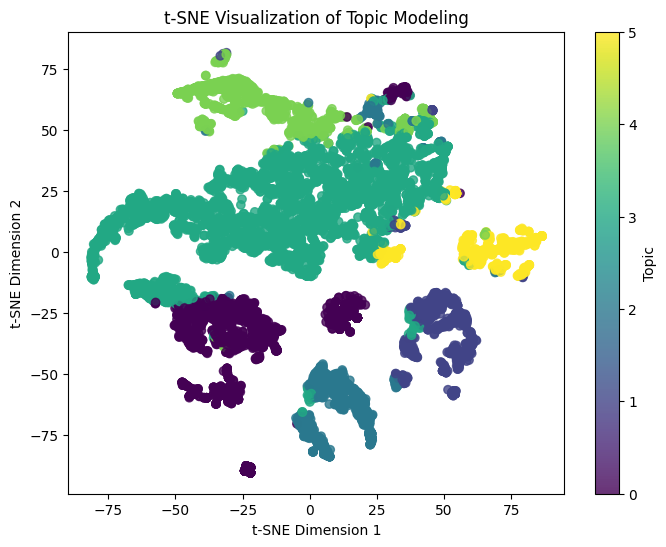

In [9]:

topics = nmf_model.transform(dtm).argmax(axis=1)

tsne = TSNE(n_components=2, perplexity=50, random_state=5000)
tsne_topic_projections = tsne.fit_transform(nmf_model.transform(dtm))

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_topic_projections[:, 0], tsne_topic_projections[:, 1], c=topics, alpha=0.8)
plt.colorbar(scatter, label="Topic")
plt.title("t-SNE Visualization of Topic Modeling")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()



We can see from this graph that we were able to make some decently defined clusters with our t-SNE model. Now we want to check if these clusters could relate to the actual labels. These labels are:

- pants-fire
- false
- barely-true
- haLf-true
- mostly-true
- true

 Our final step is to compare these results to our actual truth values to see if there’s any correlation between truth values and our model made topic modeling. If the truth values of these different clusters differ, this would suggest we could nicely separate our data by truth values as is our goal.
    
We will start by using a crosstab to visualize the amount of each truth type in each group

In [15]:
data = pd.DataFrame({
    "x": tsne_topic_projections[:, 0],
    "y": tsne_topic_projections[:, 1],
    "topic": topics,
    "true_label": df["Label"] 
})

comparison = pd.crosstab(data["topic"], data["true_label"])
comparison

true_label,barely-true,false,half-true,mostly-true,pants-fire,true
topic,,,,,,
0,373,432,397,316,185,290
1,108,114,204,232,34,170
2,175,225,193,127,137,113
3,719,838,968,960,333,820
4,195,258,215,185,112,159
5,84,128,137,142,38,124


In order to better visualize thow each of these topics may fall into one of the different truth types we have bucketed the truth types into two categoreis:

- **Falses** which contains the pants-fire, false, and barely-true labels in each topic
- **Truths** which contains the half-true, mostly-true, and true labels in each topic
- **Ratio** This is the ratio of $\frac{Truths}{Falses}$

In [33]:
falses = comparison["barely-true"] + comparison["false"] + comparison["pants-fire"]
truths = comparison["mostly-true"] + comparison["half-true"] + comparison["true"]

df_for_tf = pd.DataFrame({
    "Falses": falses,
    "Truths": truths,
    "Ratio": truths/falses
})

df_for_tf.head(6)


,Falses,Truths,Ratio
topic,,,
0,990,1003,1.013131
1,256,606,2.367188
2,537,433,0.806331
3,1890,2748,1.453968
4,565,559,0.989381
5,250,403,1.612000


From here we can see that the different topics do have significantly different truth ratios with topic 1 having 2.37 times more truths than falses and topic 2 having almost 20% less truths than falses. It is important to reference above what we have definded as truths and falses to understand the full context of this result.

## Clustering

In this section we will run a simple KMeans algorithm to test the effect of an extremely simple clustering algorithm on our data. Specifically we will be seeing if we can create an unsupervised learning model that can use statement length to differentiate the different statements into bins. We will visualize the results and comment on the performance.

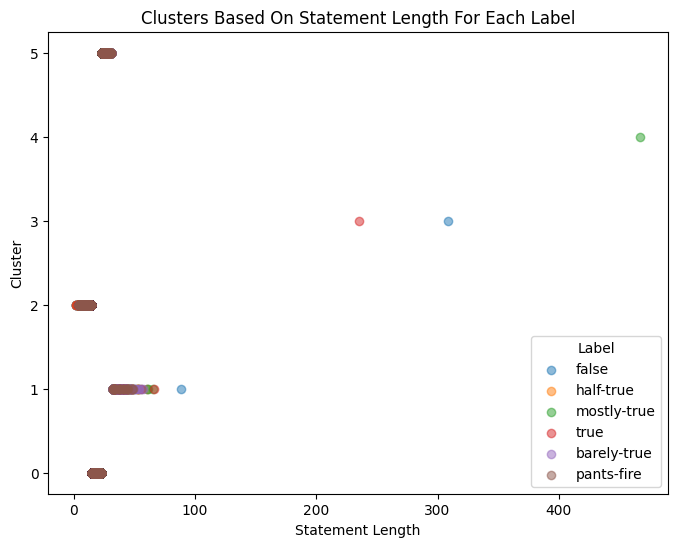

In [25]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

df['statement_length'] = df['Statement'].apply(lambda x: len(str(x).split()))

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['Label'])

X = df[['statement_length']]

kmeans = KMeans(n_clusters=6)
df['cluster'] = kmeans.fit_predict(X)

plt.figure(figsize=(8, 6))
for label in df['Label'].unique():
    subset = df[df['Label'] == label]
    plt.scatter(subset['statement_length'], subset['cluster'], label=label, alpha=0.5)

plt.title("Clusters Based On Statement Length For Each Label")
plt.xlabel("Statement Length")
plt.ylabel("Cluster")
plt.legend(title="Label")
plt.show()

We found that this clustering algorithm does not do a very good job of differentiating between different labels. This is likely for two reasons. Firstly k-means is an extremely simple model that only can use linear decision boundaries. Second the statement length may just not be a very good method in predicting a label.